In [125]:
%matplotlib inline

import pymysql.cursors
import json
import pandas as pd

# Connect to the database
connection = pymysql.connect(host='localhost',
                             user='root',
                             db='consultation_an',
                             charset='latin1',
                             cursorclass=pymysql.cursors.DictCursor)

In [126]:
results = []
affirmations = [
    "des prises de position contre une mesure existante",
    "des propositions de nouvelles mesures",
    "des questions ou demandes d'information",
    "l'évocation d'expérience(s) personnelle(s)",
    "une analyse des causes du problème",
    "une description d'un problème"]

affirmations_short = [
    'contre 1 mesure',
    'nouvelles mesures',
    'questions',
    'XP personnelle',
    'analyse des causes',
    'description pb'
]
usage = ["cite", "prend en compte", "recois", "rien", "éclaircir"]
usage_label = ["cite", "prend en compte", "reçoit", "ne fait rien", "demande à éclaircir"]
def build_result(row):
    data = json.loads(row['data'])
    if type(data) != str:
        if 'affirmations' in data:
            for p, p_short in zip(affirmations, affirmations_short):
                if p in data['affirmations']:
                    row[p_short] = 1
                else:
                    row[p_short] = 0
                
        if 'original' in data:
            row['original'] = 1 if "oui" in data['original'] else 0
        
        if 'usage' in data :
            for p, p_label in zip(usage, usage_label):
                if p in data['usage']:
                    row[p_label] = 1
                else:
                    row[p_label] = 0
            
    row.pop('data')
    return row
    
with connection.cursor() as cursor:
    sql = "SELECT `document_id`, `data` FROM `tasks`"
    cursor.execute(sql)
    results = [build_result(row) for row in cursor.fetchall()]

In [127]:
df = pd.DataFrame(data=results)
df.head()

,XP personnelle,analyse des causes,cite,contre 1 mesure,demande à éclaircir,description pb,document_id,ne fait rien,nouvelles mesures,original,prend en compte,questions,reçoit
0,0.0,0.0,1.0,0.0,0.0,0.0,339,0.0,1.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,271,0.0,1.0,1.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,43,0.0,1.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,74,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,519,0.0,0.0,0.0,1.0,0.0,0.0


## Éléments des contributions identifiés par les rapporteurs

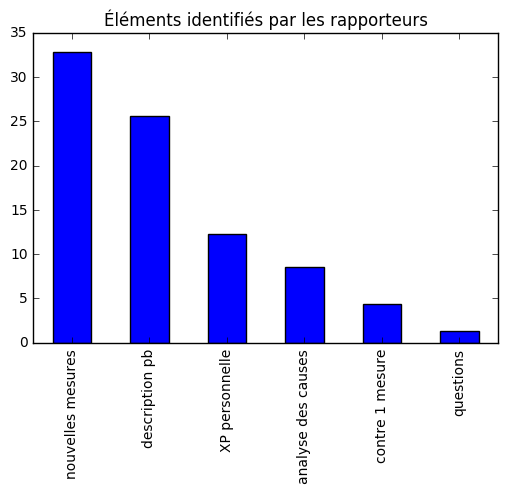

In [182]:
affirmations_total = df[affirmations_short].sum() / df.shape[0] * 100
affirmations_total.sort_values(ascending=False, inplace=True)
plot = affirmations_total.plot(
    kind='bar',
    title='Éléments identifiés par les rapporteurs')
plot.yaxis.set_label('Pourcentage de contributions (%)')

## Originalité des contributions

In [178]:
original = df[['original']].sum() / df.shape[0] * 100
original

original    30.661626
dtype: float64

## Propos les + intéressants

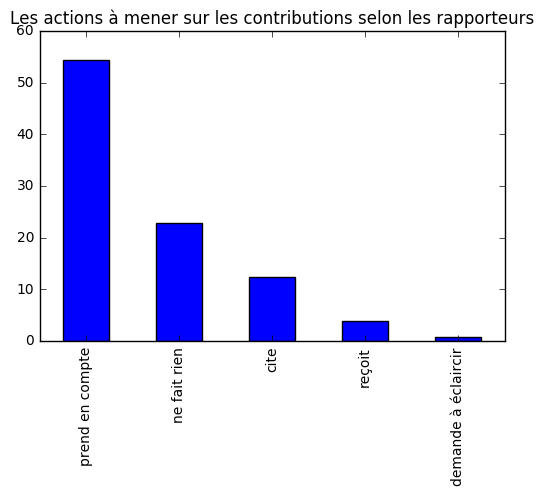

In [183]:
usage_total = df[usage_label].sum() / df.shape[0] * 100
usage_total.sort_values(inplace=True, ascending=False)
plot = usage_total.plot(
    kind='bar',
    title='Les actions à mener sur les contributions selon les rapporteurs')
plot.yaxis.set_label('Pourcentage de contributions (%)')

# Validation des contributions

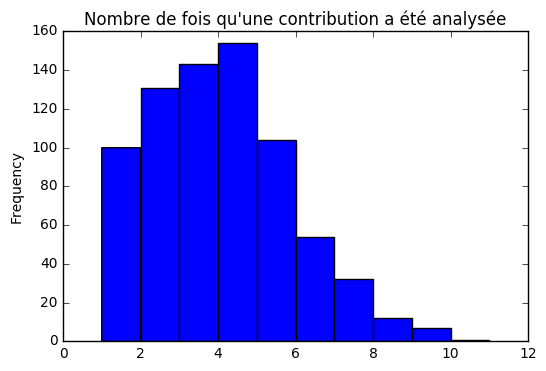

In [191]:
gp_by_document = df.groupby('document_id')
count_by_document = gp_by_document.document_id.count()
count_by_document.sort_values(ascending=False, inplace=True)
count_by_document.plot(
    kind='hist',
    #normalized=True,
    #yTitle='Pourcentage des contributions (%)',
    title='Nombre de fois qu\'une contribution a été analysée')

In [166]:
def validation_method_1(data):
    # méthode en production : éléments + originalité
    return data[affirmations_short + ['original']].duplicated().sum() > 2

def validation_method_2(data):
    # seulement sur les éléments
    return data[affirmations_short].duplicated().sum() > 2

def validation_method_3(data):
    # ok si au moins un élement est retrouvé 3x + originalité
    for p in affirmations_short:
        if data[[p, 'original']].duplicated().sum() > 2:
            return True
        
    return False

score = {'method_1': 0, 'method_2': 0, 'method_3': 0}
document_count = len(df.document_id.unique())
for _, group in gp_by_document:
    if validation_method_1(group):
        score['method_1'] += 1 / document_count
    if validation_method_2(group):
        score['method_2'] += 1 / document_count
    if validation_method_3(group):
        score['method_3'] += 1 / document_count

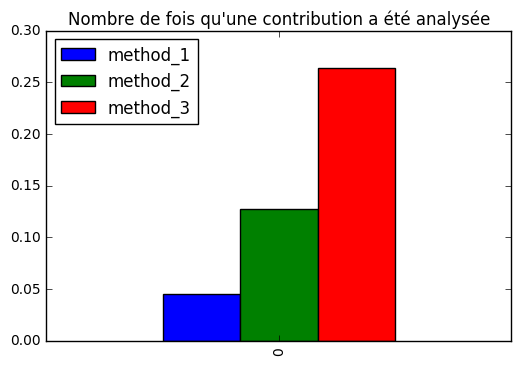

In [192]:
pd.DataFrame(data=[score]).plot(
    kind='bar',
    #yTitle='Pourcentage des contributions (%)',
    title='Pourcentage de contributions validées suivant les 3 méthodes')